# KNN for Video Recommendation — Hands-On Demo

This notebook demonstrates KNN applied to recommendation scenarios:

1. **From scratch** — Build KNN with NumPy to understand the mechanics
2. **User-based collaborative filtering** — Find similar users, recommend their videos
3. **Item-based collaborative filtering** — Find similar videos via engagement patterns
4. **Content-based retrieval** — Find similar videos via content embeddings
5. **K selection** — Cross-validation to pick the best K
6. **Scaling wall** — Demonstrate why exact KNN breaks at scale → motivates ANN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score, classification_report
import time

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
print("All imports successful!")

All imports successful!


---
## Part 1: KNN From Scratch — User Genre Classification

Given a user's watching behavior (avg watch time, % of action content watched),
classify them as an "action fan" or "comedy fan" using KNN.

In [2]:
# Synthetic user data: (avg_daily_watch_minutes, action_content_ratio)
users = {
    "Alice":   {"features": [60, 0.85], "label": "action_fan"},
    "Bob":     {"features": [45, 0.78], "label": "action_fan"},
    "Charlie": {"features": [70, 0.90], "label": "action_fan"},
    "Diana":   {"features": [30, 0.15], "label": "comedy_fan"},
    "Eve":     {"features": [50, 0.20], "label": "comedy_fan"},
    "Frank":   {"features": [40, 0.10], "label": "comedy_fan"},
    "Grace":   {"features": [55, 0.60], "label": "action_fan"},
    "Hank":    {"features": [25, 0.25], "label": "comedy_fan"},
}

X_train = np.array([u["features"] for u in users.values()])
y_train = np.array([u["label"] for u in users.values()])
names = list(users.keys())

# New user to classify
query_user = np.array([52, 0.70])
print(f"Query user: avg_watch={query_user[0]}min, action_ratio={query_user[1]}")
print(f"\nTraining data ({len(X_train)} users):")
for name, u in users.items():
    print(f"  {name:8s}  watch={u['features'][0]:3d}min  action_ratio={u['features'][1]:.2f}  → {u['label']}")

Query user: avg_watch=52.0min, action_ratio=0.7

Training data (8 users):
  Alice     watch= 60min  action_ratio=0.85  → action_fan
  Bob       watch= 45min  action_ratio=0.78  → action_fan
  Charlie   watch= 70min  action_ratio=0.90  → action_fan
  Diana     watch= 30min  action_ratio=0.15  → comedy_fan
  Eve       watch= 50min  action_ratio=0.20  → comedy_fan
  Frank     watch= 40min  action_ratio=0.10  → comedy_fan
  Grace     watch= 55min  action_ratio=0.60  → action_fan
  Hank      watch= 25min  action_ratio=0.25  → comedy_fan


In [3]:
def knn_predict(X_train, y_train, query, k, metric="euclidean"):
    """KNN from scratch — compute distances, find K nearest, majority vote."""

    # Step 1: Compute distances
    if metric == "euclidean":
        distances = np.sqrt(np.sum((X_train - query) ** 2, axis=1))
    elif metric == "cosine":
        dot = X_train @ query
        norms = np.linalg.norm(X_train, axis=1) * np.linalg.norm(query)
        distances = 1 - dot / (norms + 1e-10)
    else:
        raise ValueError(f"Unknown metric: {metric}")

    # Step 2: Find K nearest neighbors
    k_nearest_idx = np.argpartition(distances, k)[:k]
    # Sort within the K nearest for display
    sorted_order = np.argsort(distances[k_nearest_idx])
    k_nearest_idx = k_nearest_idx[sorted_order]

    # Step 3: Majority vote
    k_labels = y_train[k_nearest_idx]
    vote = Counter(k_labels)
    prediction = vote.most_common(1)[0][0]

    return prediction, k_nearest_idx, distances


# Run KNN with K=3
# IMPORTANT: We need to scale features first since watch_minutes (25-70) and
# action_ratio (0.1-0.9) are on very different scales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
query_scaled = scaler.transform(query_user.reshape(1, -1)).flatten()

for k in [1, 3, 5]:
    pred, nn_idx, dists = knn_predict(X_scaled, y_train, query_scaled, k)
    neighbors = [(names[i], y_train[i], f"{dists[i]:.3f}") for i in nn_idx]
    print(f"\nK={k}: prediction = {pred}")
    print(f"  Neighbors: {neighbors}")


K=1: prediction = action_fan
  Neighbors: [('Grace', np.str_('action_fan'), '0.381')]

K=3: prediction = action_fan
  Neighbors: [('Grace', np.str_('action_fan'), '0.381'), ('Bob', np.str_('action_fan'), '0.556'), ('Alice', np.str_('action_fan'), '0.738')]

K=5: prediction = action_fan
  Neighbors: [('Grace', np.str_('action_fan'), '0.381'), ('Bob', np.str_('action_fan'), '0.556'), ('Alice', np.str_('action_fan'), '0.738'), ('Charlie', np.str_('action_fan'), '1.422'), ('Eve', np.str_('comedy_fan'), '1.585')]


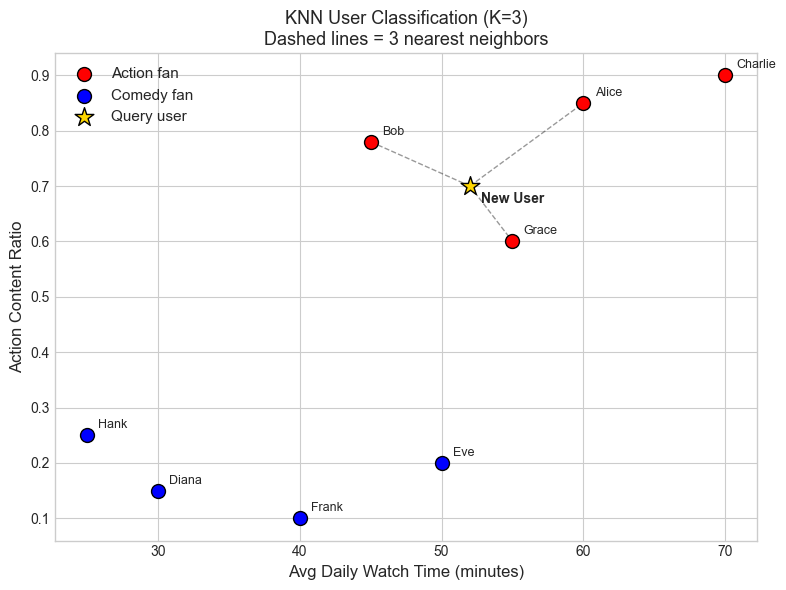

In [4]:
# Visualize the decision
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot training points
action_mask = y_train == "action_fan"
comedy_mask = y_train == "comedy_fan"

ax.scatter(X_train[action_mask, 0], X_train[action_mask, 1],
           c='red', s=100, label='Action fan', zorder=3, edgecolors='black')
ax.scatter(X_train[comedy_mask, 0], X_train[comedy_mask, 1],
           c='blue', s=100, label='Comedy fan', zorder=3, edgecolors='black')

# Plot query point
ax.scatter(query_user[0], query_user[1],
           c='gold', s=200, marker='*', label='Query user', zorder=4, edgecolors='black')

# Draw lines to K=3 nearest neighbors (use original scale for viz)
_, nn_idx, _ = knn_predict(X_scaled, y_train, query_scaled, k=3)
for i in nn_idx:
    ax.plot([query_user[0], X_train[i, 0]],
            [query_user[1], X_train[i, 1]],
            'k--', alpha=0.4, linewidth=1)

# Label each point
for i, name in enumerate(names):
    ax.annotate(name, (X_train[i, 0], X_train[i, 1]),
                textcoords="offset points", xytext=(8, 5), fontsize=9)
ax.annotate("New User", (query_user[0], query_user[1]),
            textcoords="offset points", xytext=(8, -12), fontsize=10, fontweight='bold')

ax.set_xlabel('Avg Daily Watch Time (minutes)', fontsize=12)
ax.set_ylabel('Action Content Ratio', fontsize=12)
ax.set_title('KNN User Classification (K=3)\nDashed lines = 3 nearest neighbors', fontsize=13)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

---
## Part 2: User-Based Collaborative Filtering

**Idea**: Find K users most similar to the target user → recommend videos they watched that the target hasn't seen.

This is exactly how early Netflix and Amazon recommendations worked.

In [5]:
# Simulate a user-video interaction matrix
# Rows = users, Columns = videos
# Values: 1 = watched, 0 = not watched

num_users = 50
num_videos = 30

video_names = [
    # Gaming (0-5)
    "Minecraft Stream", "CS:GO Pro Match", "Fortnite Tips",
    "League Highlights", "Zelda Walkthrough", "GTA Online",
    # ML/Tech (6-11)
    "PyTorch Tutorial", "Neural Net Math", "ML System Design",
    "CUDA Programming", "Transformer Paper", "LLM Fine-tuning",
    # Cooking (12-17)
    "Pasta Carbonara", "Sushi Making", "Thai Curry Recipe",
    "Bread Baking", "BBQ Techniques", "Vegan Meals",
    # Music (18-23)
    "Guitar Lesson", "Piano Basics", "Music Theory",
    "Beat Making", "Jazz Improvisation", "Vocal Training",
    # Fitness (24-29)
    "HIIT Workout", "Yoga Flow", "Weight Training",
    "Running Tips", "Stretching Routine", "Meal Prep Fitness",
]

# Create user profiles with cluster tendencies
# Each user has a primary interest that makes them more likely to watch those videos
interaction_matrix = np.zeros((num_users, num_videos))

for u in range(num_users):
    # Assign primary interest cluster
    primary_cluster = u % 5  # 5 clusters: gaming, ml, cooking, music, fitness
    cluster_start = primary_cluster * 6
    cluster_end = cluster_start + 6

    # High probability of watching videos in primary cluster
    for v in range(cluster_start, cluster_end):
        if np.random.random() < 0.7:
            interaction_matrix[u, v] = 1

    # Low probability of watching videos outside cluster
    for v in range(num_videos):
        if v < cluster_start or v >= cluster_end:
            if np.random.random() < 0.1:
                interaction_matrix[u, v] = 1

print(f"Interaction matrix shape: {interaction_matrix.shape}")
print(f"Sparsity: {1 - interaction_matrix.mean():.1%} (typical for real systems)")
print(f"\nSample — User 0 watched: {[video_names[i] for i in np.where(interaction_matrix[0] == 1)[0]]}")

Interaction matrix shape: (50, 30)
Sparsity: 76.9% (typical for real systems)

Sample — User 0 watched: ['Minecraft Stream', 'League Highlights', 'Zelda Walkthrough', 'GTA Online', 'PyTorch Tutorial', 'Transformer Paper', 'Meal Prep Fitness']


In [6]:
def user_based_cf_recommend(interaction_matrix, target_user_idx, k=5, n_recs=5):
    """
    User-based collaborative filtering with KNN.

    1. Find K most similar users (cosine similarity on watch vectors)
    2. Aggregate what they watched
    3. Filter out videos target already watched
    4. Rank by frequency among neighbors
    """
    target_vector = interaction_matrix[target_user_idx]

    # Compute cosine similarity to all other users
    similarities = []
    for i in range(len(interaction_matrix)):
        if i == target_user_idx:
            continue
        other = interaction_matrix[i]
        dot = np.dot(target_vector, other)
        norm = np.linalg.norm(target_vector) * np.linalg.norm(other)
        sim = dot / (norm + 1e-10)
        similarities.append((i, sim))

    # Sort by similarity (descending) and take top K
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_k = similarities[:k]

    # Aggregate videos watched by neighbors
    already_watched = set(np.where(target_vector == 1)[0])
    video_scores = Counter()

    for neighbor_idx, sim in top_k:
        neighbor_watched = np.where(interaction_matrix[neighbor_idx] == 1)[0]
        for v in neighbor_watched:
            if v not in already_watched:
                video_scores[v] += sim  # Weight by similarity

    # Return top N recommendations
    top_recs = video_scores.most_common(n_recs)
    return top_recs, top_k


# Recommend for User 0 (a gaming fan)
target_user = 0
recs, neighbors = user_based_cf_recommend(interaction_matrix, target_user, k=5, n_recs=8)

print(f"User {target_user} watched: {[video_names[i] for i in np.where(interaction_matrix[target_user] == 1)[0]]}")
print(f"\nTop-5 similar users (by cosine similarity):")
for uid, sim in neighbors:
    print(f"  User {uid:2d} (sim={sim:.3f}): {[video_names[i] for i in np.where(interaction_matrix[uid] == 1)[0]]}")

print(f"\nRecommendations for User {target_user}:")
for video_idx, score in recs:
    print(f"  {video_names[video_idx]:25s}  (score={score:.3f})")

User 0 watched: ['Minecraft Stream', 'League Highlights', 'Zelda Walkthrough', 'GTA Online', 'PyTorch Tutorial', 'Transformer Paper', 'Meal Prep Fitness']

Top-5 similar users (by cosine similarity):
  User 20 (sim=0.598): ['Minecraft Stream', 'CS:GO Pro Match', 'Fortnite Tips', 'League Highlights', 'Zelda Walkthrough', 'GTA Online', 'Transformer Paper', 'Sushi Making', 'BBQ Techniques', 'Stretching Routine']
  User 25 (sim=0.507): ['Minecraft Stream', 'Fortnite Tips', 'League Highlights', 'Zelda Walkthrough', 'Thai Curry Recipe']
  User 30 (sim=0.463): ['Minecraft Stream', 'CS:GO Pro Match', 'Fortnite Tips', 'League Highlights', 'Zelda Walkthrough', 'Yoga Flow']
  User 16 (sim=0.429): ['Minecraft Stream', 'PyTorch Tutorial', 'Neural Net Math', 'ML System Design', 'CUDA Programming', 'Transformer Paper', 'Vegan Meals']
  User 31 (sim=0.429): ['Minecraft Stream', 'PyTorch Tutorial', 'CUDA Programming', 'Transformer Paper', 'LLM Fine-tuning', 'Bread Baking', 'Running Tips']

Recommendati

---
## Part 3: Item-Based Collaborative Filtering

**Idea**: Instead of finding similar *users*, find similar *videos*.
For each video the user liked, find K most similar videos → recommend those.

This is Amazon's "Customers who watched this also watched..." approach.

**Advantage over user-based**: Item similarities are more stable (items don't change, users do).

In [7]:
def item_based_cf_recommend(interaction_matrix, target_user_idx, k=3, n_recs=8):
    """
    Item-based collaborative filtering.

    For each video the user watched:
      Find K most similar videos (by who-watched-them pattern)
      Add to candidate pool
    Rank candidates by similarity score, filter already-watched.
    """
    target_watched = np.where(interaction_matrix[target_user_idx] == 1)[0]
    already_watched = set(target_watched)

    # Item vectors: each video represented by which users watched it
    # Transpose: columns become items, rows become users
    item_vectors = interaction_matrix.T  # (num_videos, num_users)
    item_vectors_normalized = normalize(item_vectors, axis=1)  # L2 normalize rows

    # For each video the user watched, find similar videos
    candidate_scores = Counter()

    for watched_vid in target_watched:
        # Cosine similarity of this video to all others
        sims = item_vectors_normalized @ item_vectors_normalized[watched_vid]

        # Get top K similar (excluding itself)
        sims[watched_vid] = -1  # exclude self
        top_k_indices = np.argsort(sims)[-k:][::-1]

        for similar_vid in top_k_indices:
            if similar_vid not in already_watched and sims[similar_vid] > 0:
                candidate_scores[similar_vid] += sims[similar_vid]

    return candidate_scores.most_common(n_recs)


# Recommend for User 1 (an ML/tech fan based on cluster assignment)
target_user = 1
recs = item_based_cf_recommend(interaction_matrix, target_user, k=3, n_recs=8)

watched = [video_names[i] for i in np.where(interaction_matrix[target_user] == 1)[0]]
print(f"User {target_user} watched: {watched}")
print(f"\nItem-based CF Recommendations:")
for video_idx, score in recs:
    print(f"  {video_names[video_idx]:25s}  (score={score:.3f})")

User 1 watched: ['CS:GO Pro Match', 'PyTorch Tutorial', 'Neural Net Math', 'ML System Design', 'Pasta Carbonara', 'Weight Training', 'Stretching Routine']

Item-based CF Recommendations:
  Bread Baking               (score=1.088)
  CUDA Programming           (score=1.031)
  Fortnite Tips              (score=0.647)
  Meal Prep Fitness          (score=0.617)
  League Highlights          (score=0.556)
  BBQ Techniques             (score=0.555)
  Running Tips               (score=0.527)
  Transformer Paper          (score=0.516)


---
## Part 4: Content-Based Retrieval with KNN

**Idea**: Represent each video as a content embedding (simulating what a sentence-transformer would produce). Find videos closest to the user's interest profile.

This is the precursor to the Two-Tower + ANN approach used in production.

In [8]:
# Simulate content embeddings (in reality, from sentence-transformers or CLIP)
# Each video gets a 32-d embedding; videos in the same category are close together

embedding_dim = 32
category_centers = {
    "gaming":  np.random.randn(embedding_dim) * 0.3 + np.array([1, 0, 0, 0, 0] + [0]*(embedding_dim-5)),
    "ml":      np.random.randn(embedding_dim) * 0.3 + np.array([0, 1, 0, 0, 0] + [0]*(embedding_dim-5)),
    "cooking": np.random.randn(embedding_dim) * 0.3 + np.array([0, 0, 1, 0, 0] + [0]*(embedding_dim-5)),
    "music":   np.random.randn(embedding_dim) * 0.3 + np.array([0, 0, 0, 1, 0] + [0]*(embedding_dim-5)),
    "fitness": np.random.randn(embedding_dim) * 0.3 + np.array([0, 0, 0, 0, 1] + [0]*(embedding_dim-5)),
}

categories = ["gaming"]*6 + ["ml"]*6 + ["cooking"]*6 + ["music"]*6 + ["fitness"]*6

video_embeddings = np.array([
    category_centers[cat] + np.random.randn(embedding_dim) * 0.2
    for cat in categories
])
# L2 normalize
video_embeddings = normalize(video_embeddings, axis=1)

print(f"Video embeddings shape: {video_embeddings.shape}")
print(f"\nSample cosine similarities:")
sim_same = np.dot(video_embeddings[0], video_embeddings[1])     # gaming vs gaming
sim_diff = np.dot(video_embeddings[0], video_embeddings[6])     # gaming vs ML
print(f"  '{video_names[0]}' vs '{video_names[1]}' (same category): {sim_same:.3f}")
print(f"  '{video_names[0]}' vs '{video_names[6]}' (diff category): {sim_diff:.3f}")

Video embeddings shape: (30, 32)

Sample cosine similarities:
  'Minecraft Stream' vs 'CS:GO Pro Match' (same category): 0.733
  'Minecraft Stream' vs 'PyTorch Tutorial' (diff category): 0.420


In [9]:
def content_based_recommend(video_embeddings, user_watch_history, video_names,
                            k=5, n_recs=8):
    """
    Content-based retrieval using KNN.

    1. Build user profile = weighted average of watched video embeddings
    2. Find K nearest videos to the user profile
    3. Filter already-watched, return top recommendations
    """
    watched_set = set(user_watch_history)

    # Build user content profile (average of watched embeddings)
    watched_embs = video_embeddings[user_watch_history]
    user_profile = watched_embs.mean(axis=0)
    user_profile = user_profile / (np.linalg.norm(user_profile) + 1e-10)

    # KNN: find nearest videos by cosine similarity
    similarities = video_embeddings @ user_profile  # cosine sim (already normalized)

    # Sort by similarity, filter watched
    ranked_indices = np.argsort(similarities)[::-1]
    recommendations = []
    for idx in ranked_indices:
        if idx not in watched_set:
            recommendations.append((idx, similarities[idx]))
        if len(recommendations) >= n_recs:
            break

    return recommendations, user_profile


# User who watches ML content
user_history = [6, 7, 8, 10]  # PyTorch Tutorial, Neural Net Math, ML System Design, Transformer Paper

recs, profile = content_based_recommend(video_embeddings, user_history, video_names)

print(f"User's watch history:")
for idx in user_history:
    print(f"  [{categories[idx]:8s}] {video_names[idx]}")

print(f"\nContent-based recommendations (by embedding similarity):")
for idx, score in recs:
    print(f"  [{categories[idx]:8s}] {video_names[idx]:25s}  (sim={score:.3f})")

User's watch history:
  [ml      ] PyTorch Tutorial
  [ml      ] Neural Net Math
  [ml      ] ML System Design
  [ml      ] Transformer Paper

Content-based recommendations (by embedding similarity):
  [ml      ] CUDA Programming           (sim=0.860)
  [ml      ] LLM Fine-tuning            (sim=0.809)
  [gaming  ] Minecraft Stream           (sim=0.487)
  [gaming  ] Fortnite Tips              (sim=0.456)
  [gaming  ] CS:GO Pro Match            (sim=0.409)
  [gaming  ] Zelda Walkthrough          (sim=0.351)
  [gaming  ] League Highlights          (sim=0.334)
  [gaming  ] GTA Online                 (sim=0.253)


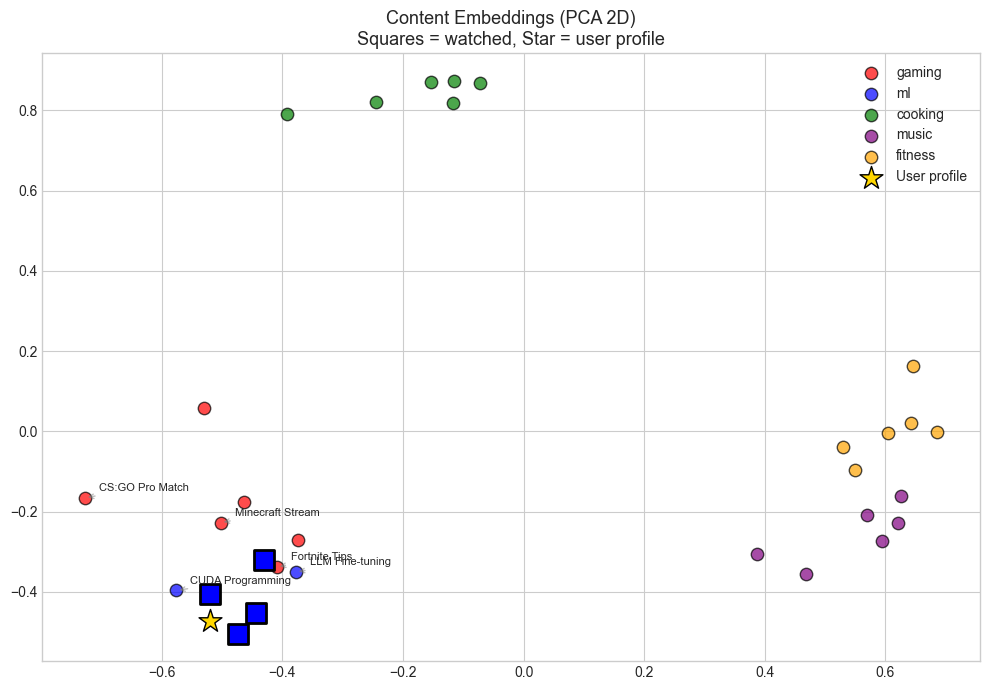

In [10]:
# Visualize embeddings in 2D using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(video_embeddings)
profile_2d = pca.transform(profile.reshape(1, -1))

fig, ax = plt.subplots(figsize=(10, 7))

colors = {"gaming": "red", "ml": "blue", "cooking": "green", "music": "purple", "fitness": "orange"}

for cat in colors:
    mask = [categories[i] == cat for i in range(num_videos)]
    ax.scatter(emb_2d[mask, 0], emb_2d[mask, 1],
              c=colors[cat], s=80, label=cat, alpha=0.7, edgecolors='black')

# Mark watched videos
for idx in user_history:
    ax.scatter(emb_2d[idx, 0], emb_2d[idx, 1],
              c=colors[categories[idx]], s=200, marker='s', edgecolors='black', linewidths=2)

# Mark user profile
ax.scatter(profile_2d[0, 0], profile_2d[0, 1],
          c='gold', s=300, marker='*', label='User profile', zorder=5, edgecolors='black')

# Label recommended videos
for idx, score in recs[:5]:
    ax.annotate(video_names[idx], (emb_2d[idx, 0], emb_2d[idx, 1]),
               textcoords="offset points", xytext=(10, 5), fontsize=8,
               arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))

ax.set_title('Content Embeddings (PCA 2D)\nSquares = watched, Star = user profile', fontsize=13)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

---
## Part 5: Choosing K with Cross-Validation

K is a **query-time hyperparameter** (not learned during training).
The best way to select K is cross-validation.

In [11]:
# Generate a larger dataset for meaningful cross-validation
from sklearn.datasets import make_classification

# Simulate: classify users into 5 preference groups based on behavioral features
X_cv, y_cv = make_classification(
    n_samples=500, n_features=10, n_informative=6,
    n_classes=5, n_clusters_per_class=1, random_state=42
)
feature_names = [
    "avg_watch_min", "action_ratio", "comedy_ratio", "tutorial_ratio",
    "music_ratio", "session_count", "avg_session_len", "mobile_pct",
    "weekend_ratio", "late_night_ratio"
]

# Scale features
scaler = StandardScaler()
X_cv_scaled = scaler.fit_transform(X_cv)

# Try different K values
k_values = [1, 3, 5, 7, 9, 11, 15, 21, 31, 51]
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='distance')
    scores = cross_val_score(knn, X_cv_scaled, y_cv, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f"K={k:3d}: accuracy = {scores.mean():.3f} ± {scores.std():.3f}")

best_k = k_values[np.argmax(cv_scores)]
print(f"\nBest K = {best_k} (accuracy = {max(cv_scores):.3f})")

K=  1: accuracy = 0.758 ± 0.031
K=  3: accuracy = 0.776 ± 0.031
K=  5: accuracy = 0.780 ± 0.028
K=  7: accuracy = 0.814 ± 0.037
K=  9: accuracy = 0.790 ± 0.024
K= 11: accuracy = 0.798 ± 0.025
K= 15: accuracy = 0.808 ± 0.023
K= 21: accuracy = 0.800 ± 0.037
K= 31: accuracy = 0.792 ± 0.029
K= 51: accuracy = 0.762 ± 0.029

Best K = 7 (accuracy = 0.814)


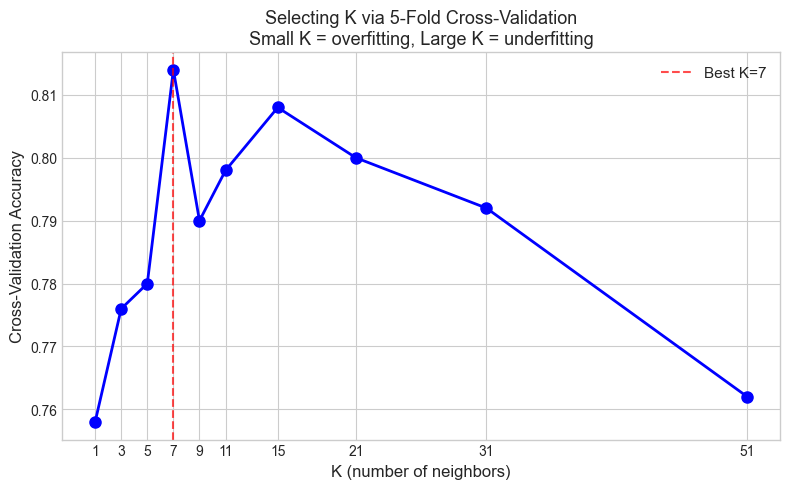

In [12]:
# Plot K vs accuracy
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(k_values, cv_scores, 'bo-', linewidth=2, markersize=8)
ax.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best K={best_k}')

ax.set_xlabel('K (number of neighbors)', fontsize=12)
ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)
ax.set_title('Selecting K via 5-Fold Cross-Validation\n'
             'Small K = overfitting, Large K = underfitting', fontsize=13)
ax.legend(fontsize=11)
ax.set_xticks(k_values)
plt.tight_layout()
plt.show()

---
## Part 6: The Scaling Wall — Why Exact KNN Breaks

KNN's query time is **O(N × D)** — it must compute distance to every single point.
Let's measure how query time grows with dataset size to see why ANN is needed.

In [13]:
# Benchmark KNN query time vs dataset size
dim = 128  # Same as Two-Tower embedding dimension
k = 100    # Retrieve top-100 candidates

sizes = [1_000, 5_000, 10_000, 50_000, 100_000, 500_000]
times_brute = []

query = np.random.randn(1, dim).astype(np.float32)

print(f"Benchmarking exact KNN (dim={dim}, K={k})")
print(f"{'N items':>12s}  {'Query time':>12s}  {'QPS @ 50K':>15s}")
print("-" * 45)

for n in sizes:
    data = np.random.randn(n, dim).astype(np.float32)

    nn = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute')
    nn.fit(data)

    # Time 20 queries and average
    start = time.time()
    num_queries = 20
    for _ in range(num_queries):
        nn.kneighbors(query)
    elapsed = (time.time() - start) / num_queries
    times_brute.append(elapsed)

    qps_achievable = 1.0 / elapsed
    feasible = "OK" if elapsed < 0.01 else "TOO SLOW"
    print(f"{n:>12,d}  {elapsed*1000:>9.2f} ms   {qps_achievable:>10,.0f} QPS  {feasible}")

# Extrapolate to 10M
# Linear scaling: time ∝ N
time_10m = times_brute[-1] * (10_000_000 / sizes[-1])
print(f"\nExtrapolated for 10M items: ~{time_10m*1000:.0f} ms per query")
print(f"That's {1/time_10m:.0f} QPS — need 50,000 QPS for YouTube-scale.")
print(f"\n→ This is why we need ANN (approximate nearest neighbors)!")

Benchmarking exact KNN (dim=128, K=100)
     N items    Query time        QPS @ 50K
---------------------------------------------
       1,000       0.52 ms        1,906 QPS  OK
       5,000       0.96 ms        1,044 QPS  OK
      10,000       1.97 ms          508 QPS  OK
      50,000       5.99 ms          167 QPS  OK
     100,000      12.64 ms           79 QPS  TOO SLOW
     500,000      66.71 ms           15 QPS  TOO SLOW

Extrapolated for 10M items: ~1334 ms per query
That's 1 QPS — need 50,000 QPS for YouTube-scale.

→ This is why we need ANN (approximate nearest neighbors)!


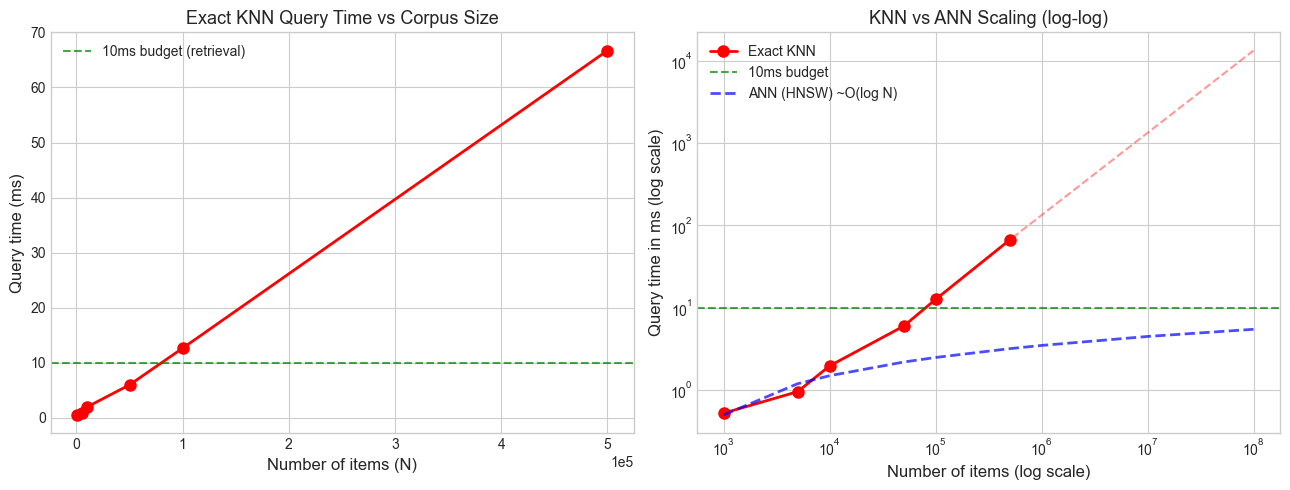

Key takeaway: Exact KNN is O(N) — works for 10K items, unusable for 10M.
ANN (HNSW, FAISS) is ~O(log N) — handles 10M+ items in <5ms.


In [14]:
# Plot scaling behavior
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Linear scale
ax1.plot(sizes, [t*1000 for t in times_brute], 'ro-', linewidth=2, markersize=8)
ax1.axhline(y=10, color='green', linestyle='--', alpha=0.7, label='10ms budget (retrieval)')
ax1.set_xlabel('Number of items (N)', fontsize=12)
ax1.set_ylabel('Query time (ms)', fontsize=12)
ax1.set_title('Exact KNN Query Time vs Corpus Size', fontsize=13)
ax1.legend(fontsize=10)
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Log-log scale (shows linear O(N) relationship)
ax2.loglog(sizes, [t*1000 for t in times_brute], 'ro-', linewidth=2, markersize=8, label='Exact KNN')
ax2.axhline(y=10, color='green', linestyle='--', alpha=0.7, label='10ms budget')
# Extrapolate to 10M and 100M
extended_sizes = sizes + [1_000_000, 10_000_000, 100_000_000]
extended_times = [t*1000 for t in times_brute]
for s in [1_000_000, 10_000_000, 100_000_000]:
    extended_times.append(times_brute[-1] * (s / sizes[-1]) * 1000)
ax2.loglog(extended_sizes, extended_times, 'r--', alpha=0.4)

# ANN approximate line (sub-linear)
ann_times = [0.5 + np.log2(s/1000) * 0.3 for s in extended_sizes]  # O(log N) approximate
ax2.loglog(extended_sizes, ann_times, 'b--', linewidth=2, alpha=0.7, label='ANN (HNSW) ~O(log N)')

ax2.set_xlabel('Number of items (log scale)', fontsize=12)
ax2.set_ylabel('Query time in ms (log scale)', fontsize=12)
ax2.set_title('KNN vs ANN Scaling (log-log)', fontsize=13)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("Key takeaway: Exact KNN is O(N) — works for 10K items, unusable for 10M.")
print("ANN (HNSW, FAISS) is ~O(log N) — handles 10M+ items in <5ms.")

---
## Part 7: Putting It All Together — Mini Recommendation Pipeline

Combine user-based CF, item-based CF, and content-based retrieval
into a simple multi-source retrieval system (like our video recommendation design).

In [ ]:
def mini_recommendation_pipeline(user_idx, interaction_matrix, video_embeddings,
                                  video_names, categories):
    """
    Simplified version of our multi-source retrieval pipeline.

    Sources:
      1. User-based CF (KNN on user vectors)
      2. Item-based CF (KNN on item vectors)
      3. Content-based (KNN on content embeddings)

    Merge, deduplicate, and rank.
    """
    print(f"{'='*60}")
    print(f"Recommendations for User {user_idx}")
    watched = [video_names[i] for i in np.where(interaction_matrix[user_idx] == 1)[0]]
    print(f"Watch history: {watched}")
    print(f"{'='*60}")

    # Source 1: User-based CF
    user_cf_recs, _ = user_based_cf_recommend(interaction_matrix, user_idx, k=5, n_recs=5)
    print(f"\nSource 1 — User-Based CF (5 recs):")
    for idx, score in user_cf_recs:
        print(f"  [{categories[idx]:8s}] {video_names[idx]:25s}  score={score:.3f}")

    # Source 2: Item-based CF
    item_cf_recs = item_based_cf_recommend(interaction_matrix, user_idx, k=3, n_recs=5)
    print(f"\nSource 2 — Item-Based CF (5 recs):")
    for idx, score in item_cf_recs:
        print(f"  [{categories[idx]:8s}] {video_names[idx]:25s}  score={score:.3f}")

    # Source 3: Content-based
    user_history = list(np.where(interaction_matrix[user_idx] == 1)[0])
    content_recs, _ = content_based_recommend(video_embeddings, user_history, video_names, k=5, n_recs=5)
    print(f"\nSource 3 — Content-Based (5 recs):")
    for idx, score in content_recs:
        print(f"  [{categories[idx]:8s}] {video_names[idx]:25s}  score={score:.3f}")

    # Merge & deduplicate (normalize scores to [0,1] per source, then sum)
    merged = Counter()
    source_map = {}  # Track which sources contributed

    for source_name, recs in [("user_cf", user_cf_recs), ("item_cf", item_cf_recs), ("content", content_recs)]:
        if recs:
            max_score = max(s for _, s in recs)
            for idx, score in recs:
                normalized = score / (max_score + 1e-10)
                merged[idx] += normalized
                source_map.setdefault(idx, []).append(source_name)

    # Final ranked list
    final = merged.most_common(8)
    print(f"\n{'─'*60}")
    print(f"FINAL MERGED RECOMMENDATIONS (top 8):")
    print(f"{'─'*60}")
    for rank, (idx, score) in enumerate(final, 1):
        sources = ", ".join(source_map[idx])
        print(f"  #{rank}  [{categories[idx]:8s}] {video_names[idx]:25s}  "
              f"score={score:.3f}  sources: {sources}")


# Run for two different users
mini_recommendation_pipeline(0, interaction_matrix, video_embeddings, video_names, categories)
print("\n")
mini_recommendation_pipeline(1, interaction_matrix, video_embeddings, video_names, categories)

---
## Summary

| What We Built | KNN Variant | Key Insight |
|--------------|-------------|-------------|
| User classification | KNN classifier (from scratch) | K is a query-time parameter, feature scaling is critical |
| User-based CF | KNN on user interaction vectors | Find similar users → recommend their videos |
| Item-based CF | KNN on item co-watch vectors | Find similar items → more stable than user-based |
| Content retrieval | KNN on content embeddings | Works for cold-start (new videos) |
| K selection | Cross-validation sweep | Small K overfits, large K underfits |
| Scaling benchmark | Brute-force timing | O(N×D) per query → unusable at 10M+ items |
| Mini pipeline | Multi-source merge | Combining sources improves coverage |

### Connection to Production Systems

Everything in this notebook is the **conceptual foundation** of what YouTube/TikTok do at scale:

```
This notebook                    Production system
─────────────                    ─────────────────
Handcrafted features       →     Learned embeddings (Two-Tower model)
Exact KNN search           →     ANN search (FAISS/ScaNN, <5ms)
Cosine similarity          →     Dot product on L2-normalized embeddings
Multi-source merge         →     Retrieval orchestrator with 5 sources
Score-based ranking        →     Multi-task deep ranking model (MMoE)
```

The upgrade path: **better features** (learned vs. handcrafted) + **faster search** (ANN vs. exact).